In [36]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

file_path = r"C:\Users\nstep\TSU\SeniorProject\df_selected1.csv"
nashvilleDF = pd.read_csv(file_path)

In [37]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

In [38]:
print(nashvilleDF.shape)

nashvilleDF.head()

(8580, 31)


,grill,private entrance,free parking,review_scores_location,resort access,review_scores_rating,bedrooms,beds,pool,host_acceptance_rate,...,prop_Entire condo,prop_Entire guest suite,prop_Entire guesthouse,prop_Entire home,prop_Entire rental unit,prop_Entire townhouse,prop_Hotel,prop_Private room,room_Entire home/apt,room_Private room
0,0,0,0,4.92,0,4.95,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,1,4.94,0,4.94,1,1,0,93,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,4.96,0,4.91,2,2,0,100,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,4.74,0,4.77,1,2,0,91,...,0,0,0,0,0,0,0,1,0,1
4,0,0,1,4.47,0,4.71,1,3,0,91,...,0,0,0,0,0,0,0,1,0,1


In [39]:
# Drop rows where any of the specified columns has a value of 1
columns_to_check = ['prop_Entire condo', 'prop_Entire guest suite', 'prop_Entire guesthouse',
                    'prop_Entire rental unit', 'prop_Entire townhouse', 'prop_Hotel',
                    'prop_Private room', 'free parking', 'room_Private room']

nashvilleDF = nashvilleDF[~nashvilleDF[columns_to_check].eq(1).any(axis=1)]

# Drop 'id' and the specified columns
columns_to_drop = ['id','prop_Entire home', 'room_Entire home/apt',] + columns_to_check
nashvilleDF = nashvilleDF.drop(columns=columns_to_drop)
nashvilleDF.head()

,grill,private entrance,review_scores_location,resort access,review_scores_rating,bedrooms,beds,pool,host_acceptance_rate,reviews_per_month,minimum_maximum_nights,minimum_minimum_nights,bathrooms,neighbourhood_cleansed_num,accommodates,hot tub,fireplace,price,host_is_superhost
64,1,1,4.96,0,4.80,3,4,0,100,7.45,1125,1,1.5,17,9,0,0,247,1
93,0,1,4.87,0,4.95,1,1,0,100,3.43,1125,2,1.0,6,2,0,1,119,1
97,0,1,4.97,0,4.93,1,2,0,99,1.78,59,1,1.0,6,4,0,0,161,0
103,0,0,4.26,0,4.68,3,3,0,100,7.30,1125,1,1.0,17,6,0,0,136,0
124,1,0,4.97,0,4.81,2,3,0,100,3.16,1125,2,2.0,6,6,0,0,184,1


In [40]:
import graphviz

# Given DOT representation
causal_graph_updated = f"""
digraph {{
    grill -> price;
    pool -> price;
    "hot tub" -> price;
    "hot tub" -> bathrooms;
    pool -> bathrooms;
    "private entrance" -> price;
    "private entrance" -> "resort access";
    fireplace -> price;

    neighbourhood_cleansed_num -> price;
    neighbourhood_cleansed_num -> review_scores_location;
    review_scores_location -> review_scores_rating;
    review_scores_location -> reviews_per_month;
    review_scores_rating -> reviews_per_month;
    reviews_per_month -> price;
    host_is_superhost -> reviews_per_month;
    host_is_superhost -> price;
    host_is_superhost -> review_scores_rating;
    host_acceptance_rate -> reviews_per_month;
    host_acceptance_rate -> price;
    beds -> bedrooms;
    bedrooms -> accommodates;
    bedrooms -> bathrooms;
    accommodates -> price;
    "resort access" -> pool;
    "resort access" -> "hot tub";
    pool -> host_acceptance_rate;
    "hot tub" -> host_acceptance_rate;
    bathrooms -> price;
    minimum_minimum_nights -> price;
    minimum_maximum_nights -> price;

    "resort access" -> price;
}}
"""


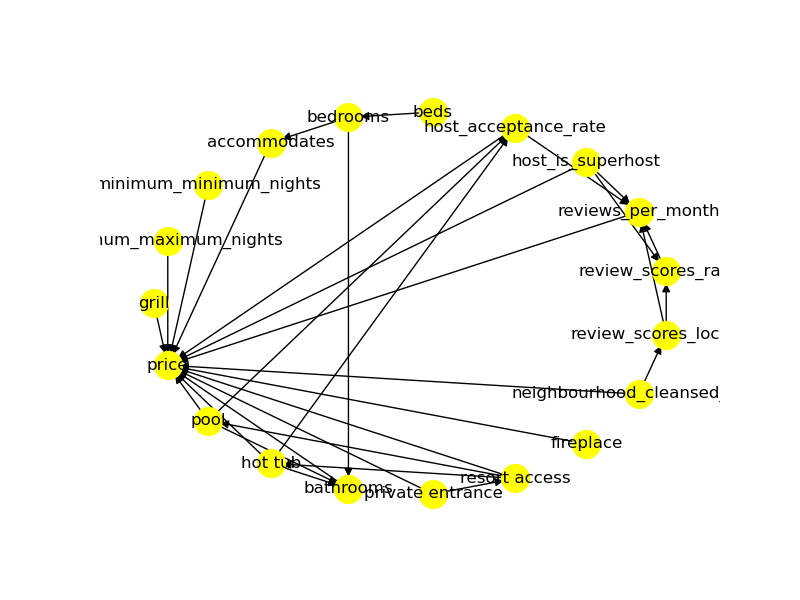

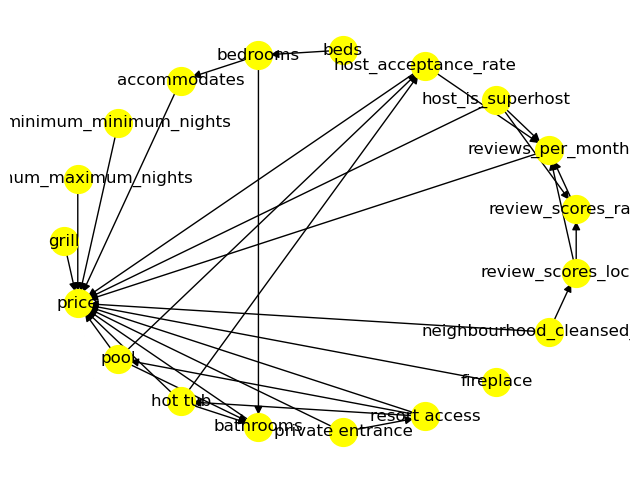

In [41]:

model=CausalModel(
        data = nashvilleDF,
        treatment='beds',
        outcome='price',
        graph=causal_graph_updated)

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [42]:
# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d             
───────(E[price])
d[beds]          
Estimand assumption 1, Unconfoundedness: If U→{beds} and U→price then P(price|beds,,U) = P(price|beds,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡     d                d               ⎤
E⎢───────────(price)⋅───────([bedrooms])⎥
 ⎣d[bedrooms]        d[beds]            ⎦
Estimand assumption 1, Full-mediation: bedrooms intercepts (blocks) all directed paths from beds to p,r,i,c,e.
Estimand assumption 2, First-stage-unconfoundedness: If U→{beds} and U→{bedrooms} then P(bedrooms|beds,U) = P(bedrooms|beds)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{bedrooms} and U→price then P(price|bedrooms, beds, U) = P(price|bedrooms, beds)



In [43]:
import pickle
import matplotlib.pyplot as plt

import econml
import dowhy
from dowhy import CausalModel


estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 control_value=0,
                                 treatment_value=1,
                                 confidence_intervals=True,
                                 test_significance=True)
print(estimate)


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': ['private entrance', 'host_is_superhost', 'review_scores_rating', 'host_acceptance_rate', 'resort access', 'reviews_per_month', 'neighbourhood_cleansed_num', 'pool', 'grill', 'fireplace', 'review_scores_location', 'minimum_maximum_nights', 'hot tub', 'minimum_minimum_nights']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['private entrance', 'host_is_superhost', 'review_scores_rating', 'host_acceptance_rate', 'resort access', 'reviews_per_month', 'neighbourhood_cleansed_num', 'pool', 'grill', 'fireplace', 'review_scores_location', 'minimum_maximum_nights', 'hot tub', 'minimum_minimum_nights']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': Fals

In [44]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 31.60269294929546


100%|██████████| 4000/4000 [12:29<00:00,  5.33it/s, disc=6.1, gen=-1.6, regul_loss=0.797, tot=39]             


Method : LiNGAM


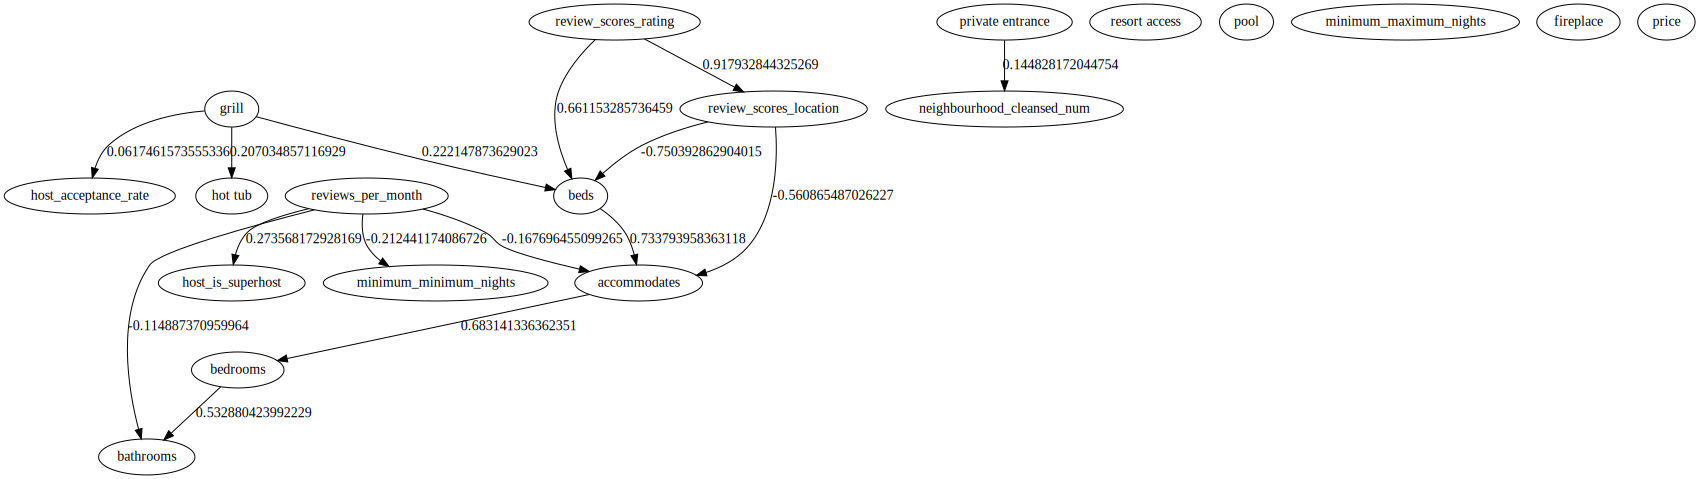

Method : PC


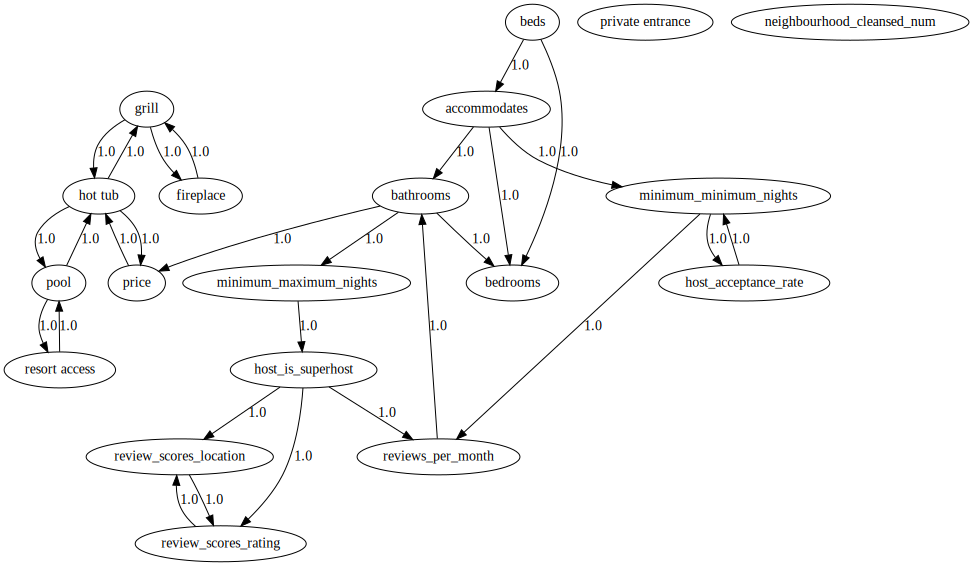

Method : GES


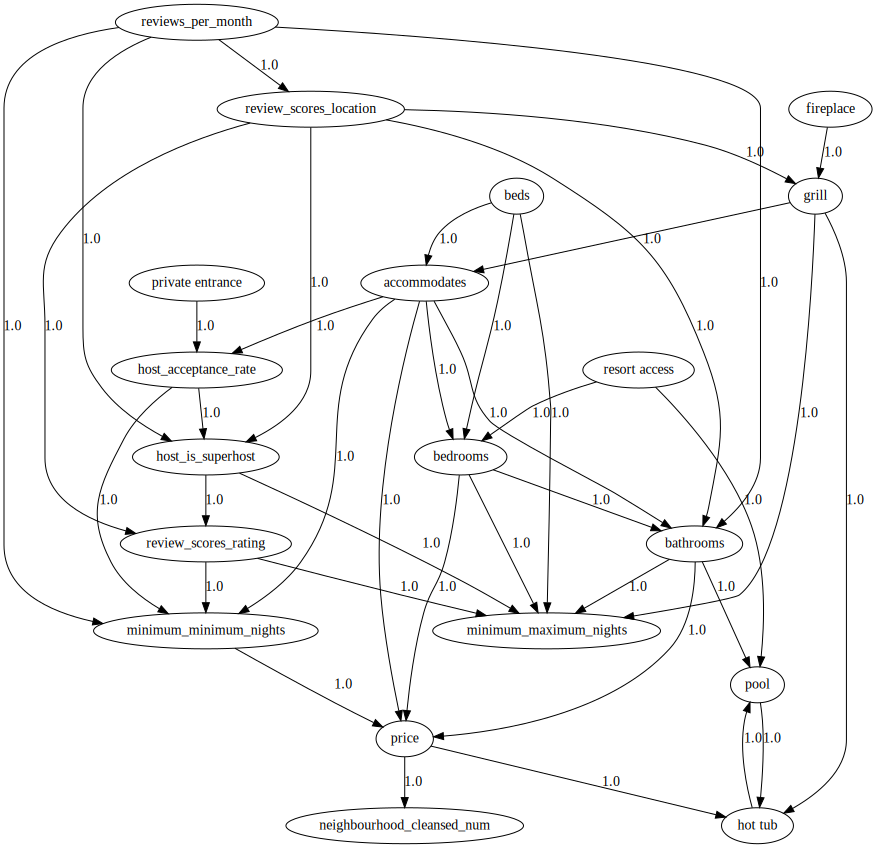

Method : SAM


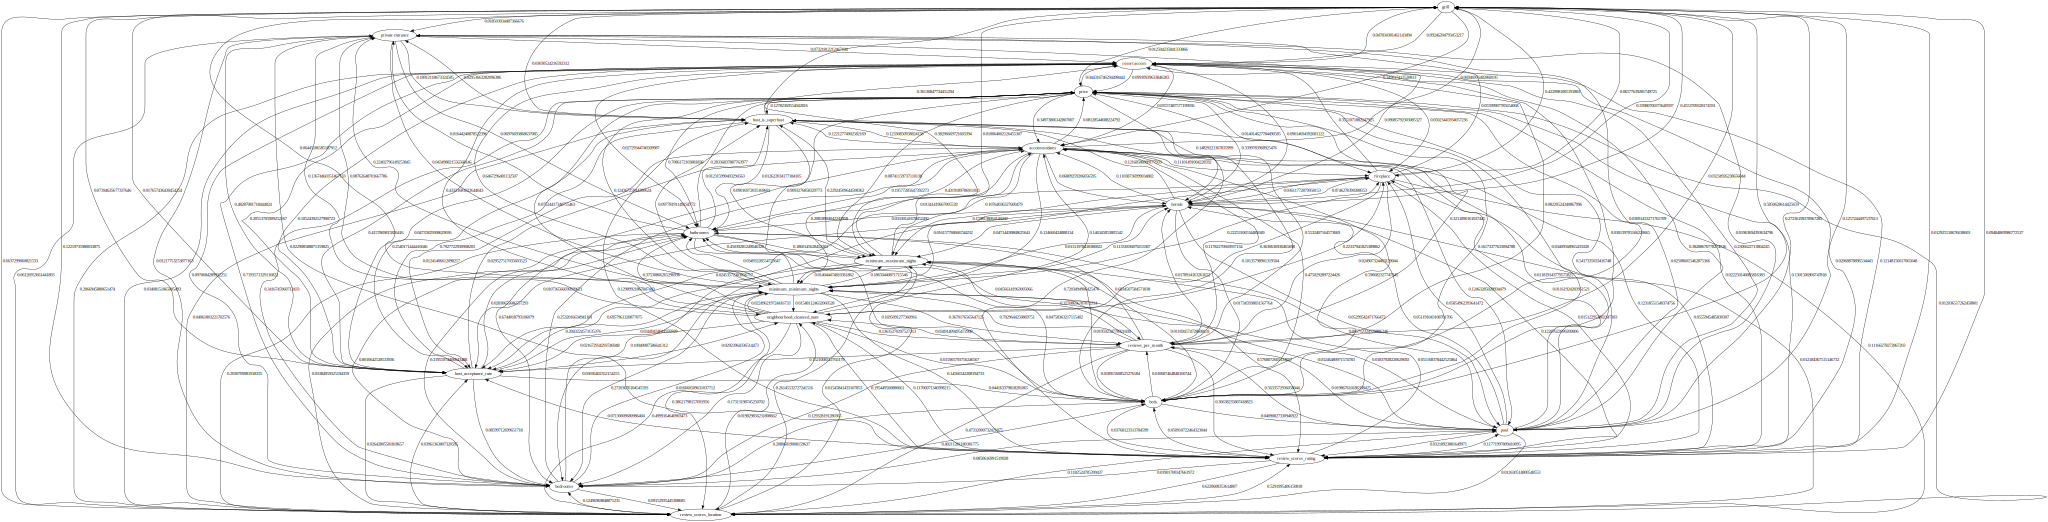

In [46]:
from cdt.causality.graph import LiNGAM, PC, GES, SAM,CAM 
import graphviz
from sklearn.preprocessing import StandardScaler


import os
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.3.1'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

scaler = StandardScaler()
nashvilleDF_scaled = pd.DataFrame(scaler.fit_transform(nashvilleDF), columns=nashvilleDF.columns)
from sklearn.decomposition import PCA

pca = PCA(n_components=min(nashvilleDF_scaled.shape) - 1)  # -1 to ensure the matrix is non-singular
nashvilleDF_pca = pca.fit_transform(nashvilleDF_scaled)




graphs = {}
labels = [f'{col}' for i, col in enumerate(nashvilleDF.columns)]
functions = {
    'LiNGAM' : LiNGAM,
    'PC': PC,
    'GES': GES,
    'SAM': SAM,
}


for method, lib in functions.items():
    obj = lib()
    output = obj.predict(nashvilleDF_scaled)
    adj_matrix = nx.to_numpy_array(output)
    adj_matrix = np.asarray(adj_matrix)
    graph_dot = make_graph(adj_matrix, labels)
    graphs[method] = graph_dot

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s" % (method))
    display(graph)


In [47]:
print(nashvilleDF.head())

     grill  private entrance  review_scores_location  resort access  \
64       1                 1                    4.96              0   
93       0                 1                    4.87              0   
97       0                 1                    4.97              0   
103      0                 0                    4.26              0   
124      1                 0                    4.97              0   

     review_scores_rating  bedrooms  beds  pool  host_acceptance_rate  \
64                   4.80         3     4     0                   100   
93                   4.95         1     1     0                   100   
97                   4.93         1     2     0                    99   
103                  4.68         3     3     0                   100   
124                  4.81         2     3     0                   100   

     reviews_per_month  minimum_maximum_nights  minimum_minimum_nights  \
64                7.45                    1125              

In [7]:
for method, graph in graphs.items():
        if method != "LiNGAM":
            continue
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph_dot = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = nashvilleDF,
                treatment='accommodates',
                outcome='price',
                graph=graph_dot)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        print(identified_estimand)

        # Estimation
        estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        confidence_intervals=True,
                                        test_significance=True)
        print("Causal Estimate is " + str(estimate.value))


*****************************************************************************

Causal Discovery Method : LiNGAM
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[price|beds,pool,minimum_minimum_nights,reviews_per_month,pri
d[accommodates]                                                               

                                  
vate entrance,bathrooms,bedrooms])
                                  
Estimand assumption 1, Unconfoundedness: If U→{accommodates} and U→price then P(price|accommodates,beds,pool,minimum_minimum_nights,reviews_per_month,private entrance,bathrooms,bedrooms,U) = P(price|accommodates,beds,pool,minimum_minimum_nights,reviews_per_month,private entrance,bathrooms,bedrooms)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regress

In [20]:

# Create the updated causal graph
causal_graph_updated = f"""
digraph {{
  beds -> bedrooms;
  bedrooms -> accommodates;
  bedrooms -> price;
  accommodates -> price;
  number_of_reviews -> price;
  review_scores_rating -> price;
  neighbourhood_cleansed_num -> bedrooms;
  neighbourhood_cleansed_num -> accommodates;
  neighbourhood_cleansed_num -> price;
  pool -> price;
  host_is_superhost -> price;
  accommodates -> bathrooms;
  bathrooms -> price;
  "hot tub" -> price;
  host_response_time -> price;
}}
"""


#visualize the updated causal graph
graph = graphviz.Source(causal_graph_updated)
graph # display the graph


# Define Causal Model
model=CausalModel(
        data = nashvilleDF,
        treatment='accommodates',
        outcome='price',
        graph=causal_graph_updated)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 control_value=0,
                                 treatment_value=1,
                                 confidence_intervals=True,
                                 test_significance=True)
print("Causal Estimate is " + str(estimate.value))

TypeError: can only concatenate str (not "ParseException") to str

In [33]:

# Create the updated causal graph
causal_graph_updated = f"""
digraph {{
  beds -> bedrooms;
  bedrooms -> accommodates;
  bedrooms -> price;
  accommodates -> price;
  number_of_reviews -> price;
  minimum_minimum_nights -> price;
  review_scores_rating -> price;
  neighbourhood_cleansed_num -> bedrooms;
  neighbourhood_cleansed_num -> accommodates;
  neighbourhood_cleansed_num -> price;
  pool -> price;
  host_is_superhost -> price;
  accommodates -> bathrooms;
  bathrooms -> price;
  "hot tub" -> price;
  host_response_time -> price;
}}
"""


#visualize the updated causal graph
graph = graphviz.Source(causal_graph_updated)
graph # display the graph



# Define Causal Model
model=CausalModel(
        data = nashvilleDF,
        treatment='minimum_minimum_nights',
        outcome='price',
        graph=causal_graph_updated)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 control_value=0,
                                 treatment_value=1,
                                 confidence_intervals=True,
                                 test_significance=True)
print("Causal Estimate is " + str(estimate.value))


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                      
─────────────────────────(E[price])
d[minimum_minimum_nights]          
Estimand assumption 1, Unconfoundedness: If U→{minimum_minimum_nights} and U→price then P(price|minimum_minimum_nights,,U) = P(price|minimum_minimum_nights,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': ['beds', 'number_of_reviews', 'hot tub', 'pool', 'accommodates', 'neighbourhood_cleansed_num', 'host_is_superhost', 'bathrooms', 'review_scores_rating', 'bedrooms', 'host_response_time']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_in

KeyboardInterrupt: 

In [31]:
import graphviz

# Given DOT representation
causal_graph_updated = f"""
digraph {{
    grill -> price;
    private_entrance -> price;
    free_parking -> price;
    pool -> price;
    pool -> grill;
    "hot tub" -> price;
    "hot tub" -> pool;
    "hot tub" -> bathrooms;
    pool -> bathrooms;
    pool -> "hot tub";
    

    fireplace -> price;
    prop_Entire_Home -> price;
    
    neighbourhood_cleansed_num -> price;
    neighbourhood_cleansed_num -> review_scores_location;
    
    review_scores_location -> reviews_per_month;
    review_scores_rating -> reviews_per_month;
    reviews_per_month -> price;
    host_is_superhost -> reviews_per_month;
    host_is_superhost -> price;
    host_is_superhost -> review_scores_rating;
    host_acceptance_rate -> reviews_per_month;
    host_acceptance_rate -> price;
    bedrooms -> accommodates;
    beds -> bedrooms;
    beds -> accommodates;
    accommodates -> bathrooms;
    accommodates -> price;
    "resort access" -> pool;
    "resort access" -> "hot tub";
    bathrooms -> price;
    bathrooms -> bedrooms;

    
    minimum_minimum_nights -> price;
    minimum_maximum_nights -> price;
    
    "resort access" -> price;
}}
"""

# Visualize the graph
graph = graphviz.Source(causal_graph_updated)
graph.view()


'Source.gv.pdf'

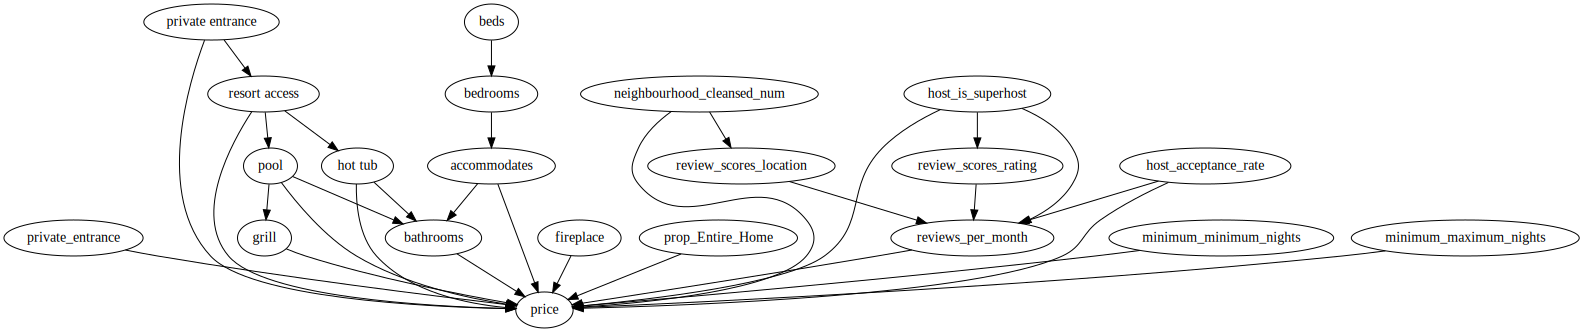

In [6]:
import graphviz

# Given DOT representation
causal_graph_updated = f"""
digraph {{
    grill -> price;
    private_entrance -> price;
    pool -> price;
    pool -> grill;
    "hot tub" -> price;
    "hot tub" -> bathrooms;
    pool -> bathrooms;
    "private entrance" -> price;
    "private entrance" -> "resort access";
    fireplace -> price;
    prop_Entire_Home -> price;
    
    neighbourhood_cleansed_num -> price;
    neighbourhood_cleansed_num -> review_scores_location;
    
    review_scores_location -> reviews_per_month;
    review_scores_rating -> reviews_per_month;
    reviews_per_month -> price;
    host_is_superhost -> reviews_per_month;
    host_is_superhost -> price;
    host_is_superhost -> review_scores_rating;
    host_acceptance_rate -> reviews_per_month;
    host_acceptance_rate -> price;
    beds -> bedrooms;
    bedrooms -> accommodates;
    accommodates -> bathrooms;
    accommodates -> price;
    "resort access" -> pool;
    "resort access" -> "hot tub";
    bathrooms -> price;
    
    minimum_minimum_nights -> price;
    minimum_maximum_nights -> price;
    
    "resort access" -> price;
}}
"""



#visualize the updated causal graph
graph = graphviz.Source(causal_graph_updated)
graph # display the graph


In [44]:



# Define Causal Model
model=CausalModel(
        data = nashvilleDF,
        treatment='accommodates',
        outcome='price',
        graph=causal_graph_updated)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 control_value=0,
                                 treatment_value=1,
                                 confidence_intervals=True,
                                 test_significance=True)
print("Causal Estimate is " + str(estimate.value))


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                 
───────────────(E[price])
d[accommodates]          
Estimand assumption 1, Unconfoundedness: If U→{accommodates} and U→price then P(price|accommodates,,U) = P(price|accommodates,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                -1⎤
 ⎢     d             ⎛     d                     ⎞  ⎥
E⎢───────────(price)⋅⎜───────────([accommodates])⎟  ⎥
 ⎣d[bedrooms]        ⎝d[bedrooms]                ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→price then ¬(U →→{bedrooms})
Estimand assumption 2, Exclusion: If we remove {bedrooms}→{accommodates}, then ¬({bedrooms}→price)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect

In [45]:
import pandas as pd

def run_causal_analysis(treatment):
    # Correlation
    correlation_score = nashvilleDF[treatment].corr(nashvilleDF['price'])
    
    # Define Causal Model
    model = CausalModel(
            data = nashvilleDF,
            treatment=treatment,
            outcome='price',
            graph=causal_graph_updated)

    # Identification
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    # Estimation
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                     control_value=0,
                                     treatment_value=1,
                                     confidence_intervals=True,
                                     test_significance=True)
    
    print(f"{treatment}: Correlation = {correlation_score:.4f}, Causal Estimate = {estimate.value:.4f}")

# List of treatments
treatments = [col for col in nashvilleDF.columns if col not in ['price', 'id']]

# Run the analysis for each treatment
for treatment in treatments:
    run_causal_analysis(treatment)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': ['beds', 'minimum_maximum_nights', 'host_acceptance_rate', 'fireplace', 'hot tub', 'review_scores_location', 'reviews_per_month', 'private_entrance', 'bathrooms', 'prop_Entire_Home', 'free_parking', 'neighbourhood_cleansed_num', 'accommodates', 'host_is_superhost', 'minimum_minimum_nights', 'review_scores_rating', 'bedrooms']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['beds', 'minimum_maximum_nights', 'host_acceptance_rate', 'fireplace', 'hot tub', 'review_scores_location', 'reviews_per_month', 'bathrooms', 'neighbourhood_cleansed_num', 'accommodates', 'host_is_superhost', 'minimum_minimum_nights', 'review_scores_rating', 'bedrooms']}


KeyboardInterrupt: 

In [7]:
import pandas as pd
from joblib import Parallel, delayed

def run_causal_analysis(treatment):
    # Correlation
    correlation_score = nashvilleDF[treatment].corr(nashvilleDF['price'])
    
    # Define Causal Model
    model = CausalModel(
            data = nashvilleDF,
            treatment=treatment,
            outcome='price',
            graph=causal_graph_updated)

    # Identification
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    # Estimation
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                     control_value=0,
                                     treatment_value=1,
                                     confidence_intervals=True,
                                     test_significance=True)
    
    return f"{treatment}: Correlation = {correlation_score:.4f}, Causal Estimate = {estimate.value:.4f}"

# List of treatments
treatments = [col for col in nashvilleDF.columns if col not in ['price', 'id']]

# Run the analysis for each treatment in parallel
results = Parallel(n_jobs=-1)(delayed(run_causal_analysis)(treatment) for treatment in treatments)

# Print results
for result in results:
    print(result)


In [7]:
import pandas as pd
from joblib import Parallel, delayed

def run_causal_analysis(treatment):
    # Correlation
    correlation_score = nashvilleDF[treatment].corr(nashvilleDF['price'])
    
    # Define Causal Model
    model = CausalModel(
            data = nashvilleDF,
            treatment=treatment,
            outcome='price',
            graph=causal_graph_updated)

    # Identification
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    # Estimation
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                     control_value=0,
                                     treatment_value=1,
                                     confidence_intervals=True,
                                     test_significance=True)
    
    return treatment, correlation_score, estimate.value

# List of treatments
treatments = [col for col in nashvilleDF.columns if col not in ['price', 'id']]

# Run the analysis for each treatment in parallel
results = Parallel(n_jobs=-1)(delayed(run_causal_analysis)(treatment) for treatment in treatments)

# Calculate differences and sort
sorted_results = sorted(results, key=lambda x: abs(x[1] - x[2]), reverse=True)

# Buckets
buckets = {
    "high correlation, high causation": [],
    "high correlation, low causation": [],
    "low correlation, high causation": [],
    "low correlation, low causation": []
}

# Categorize top 5 results into buckets
for treatment, correlation, causation in sorted_results[:5]:
    if correlation > causation:
        if correlation > 0 and causation > 0:
            buckets["high correlation, high causation"].append(treatment)
        else:
            buckets["high correlation, low causation"].append(treatment)
    else:
        if correlation > 0 and causation > 0:
            buckets["low correlation, high causation"].append(treatment)
        else:
            buckets["low correlation, low causation"].append(treatment)

# Print results
for category, treatments in buckets.items():
    print(f"{category}: {', '.join(treatments)}\n")
